In [1]:
#from structure_and_load import load
import os
import scipy.io as sio 
import pandas as pd
import numpy as np
import scipy.ndimage as spn 

from neo.core import Event
from quantities import millisecond as ms
from neo.core import SpikeTrain
from elephant.statistics import mean_firing_rate

import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
def matlab_file_(path):
    """
    Open a matlab behaviour structure from OrganizeBehaviour and save it in a python dictionary. One
    SESSION corresponds to one behavioural file - independently of the number of probes.
    :param filename: name of the matlab structure containing the behavioural information
    :return: behaviour: dictionary containing the same fields as the behaviour structure from matlab
    """
    # initialize a counter for the number of files loaded
    n_file = -1
    # get filenames in list in the session directory
    filenames = os.listdir(path)

    data = [] 
    load_info = []
    
    # Loop through MATLAB files in the session directory
    for matfile in filenames:

        n_file += 1  
        print(f'loading {matfile}')
        load_info.append((n_file, matfile))

        # get the full file path for the current file and load MATLAB file
        filepath = os.path.join(path, matfile) 
        matfile = sio.loadmat(filepath)

        # get the name of the sub-structure within the MATLAB file
        data_str_name = list(matfile.keys())[-1]

        # get the field names within the sub-structure and use them as keys for the new dictionary
        fields = []
        for key in matfile[data_str_name].dtype.fields.keys():
            fields.append(key)

        # Extract the data inside the sub-structure and save dictionnary in list
        data_ = matfile[data_str_name][0][0]
        data.append({field: data_[i_field][:, 0] for i_field, field in enumerate(fields)})
        

    print(f'\n{n_file + 1} files loaded')
    
    return data, load_info



In [3]:
lab_desktop = False

if lab_desktop : 
    path = '/home/INT/mifsud.l/Bureau/results'
    laminar_info_path = '/home/INT/mifsud.l/Bureau/Lists&Documentation/laminar_info/docs/TommyLaminarInfo.xlsx'
    session = 't150327002'

else : 
    session = 't150204001'
    data_path = f'/home/laurie/Bureau/pattern_classification/data/Tommy_new/{session}/modified_data/'
    info_path = '/home/laurie/Bureau/pattern_classification/data/Tommy_new/session_info.xlsx'
    result_path = '/home/laurie/Bureau/pattern_classification/results/classif_new_data'
    laminar_info_path = '/home/laurie/Bureau/pattern_classification/data/Tommy_new/TommyLaminarInfo.xlsx'
    

laminar_info = pd.read_excel(laminar_info_path)

#load data
data, load_info = matlab_file_(data_path)

loading t150204001_probe1_contact6_unit1.mat
loading t150204001_probe2_contact24_unit1.mat
loading t150204001_probe1_contact19_unit1.mat
loading t150204001_probe1_contact17_unit1.mat
loading t150204001_probe1_contact12_unit1.mat
loading t150204001_probe2_contact7_unit4.mat
loading t150204001_probe2_contact14_unit1.mat
loading t150204001_probe2_contact9_unit3.mat
loading t150204001_probe1_contact1_unit1.mat
loading t150204001_probe2_contact23_unit1.mat
loading t150204001_probe2_contact19_unit1.mat
loading t150204001_probe2_contact8_unit1.mat
loading t150204001_probe2_contact21_unit1.mat
loading t150204001_probe1_contact5_unit1.mat
loading t150204001_probe1_contact13_unit1.mat
loading t150204001_probe2_contact10_unit1.mat
loading t150204001_probe2_contact9_unit1.mat
loading t150204001_probe1_contact11_unit3.mat
loading t150204001_probe1_contact4_unit1.mat
loading t150204001_probe2_contact5_unit1.mat
loading t150204001_probe2_contact18_unit1.mat
loading t150204001_probe2_contact2_unit1.ma

In [4]:
import re
df = pd.read_excel(info_path)
df.dropna(how='all', inplace=True)
df.drop(columns=['BehDir', 'pitch', 'A/P', 'Lat', 'depth', 'SNR', 'Unnamed: 14', 'depth (no buffer)'], inplace=True)
df.rename(columns={'%Plexon_spike_file' : 'Plexon_spike_file'}, inplace=True)
float_column_names = df.select_dtypes(include=['float']).columns
df[float_column_names] = df[float_column_names].astype(int)

list_prob = []
list_chan = []
list_unit = []

info_units = []

for i in range(len(load_info)) :
    matfile = load_info[i][1]
    # get contact and unit indices from filename
    match_probe = re.search(r'probe(\d+)', matfile)
    match_contact = re.search(r'contact(\d+)', matfile)
    match_unit = re.search(r'unit(\d+)', matfile)

    info_units.append({
        'probe':int(match_probe.group(1)), 
        'contact':int(match_contact.group(1)), 
        'unit':int(match_unit.group(1))})


    list_prob.append(int(match_probe.group(1)))
    list_chan.append(int(match_contact.group(1)))
    list_unit.append(int(match_unit.group(1)))

#info_units = pd.DataFrame(info_units)
sub_info_session = df[df['Plexon_spike_file'].str.startswith(f'{session}')]


info_session = pd.DataFrame()
list_idx = []
for i in range(len(list_unit)):
    sub_data = sub_info_session[(sub_info_session['probe'] == list_prob[i]) & (sub_info_session['channel'] == list_chan[i]) & (sub_info_session['unit'] == list_unit[i])]
    list_idx.append(sub_data.index[0])
    info_session = pd.concat((info_session, sub_data))

def convert_elitrials(entry):
    if pd.notna(entry):  # Check for NaN
        # Remove square brackets and split by space to separate pairs
        pairs = entry.replace('[', '').replace(']', '').split()
        result = []
        for pair in pairs:
            start, end = map(int, pair.split(':'))
            result.append([start, end])
        return result
    else:
        return None
        
info_session['elitrials'] = info_session['elitrials'].apply(convert_elitrials)

In [5]:
info_session

,Plexon_spike_file,probe,channel,unit,start,stop,"SUA (1), MUA (2), unstable (3) few trials (4) or observation (5)",elitrials
162,t150204001_chan_01_24_new,1,6,1,8,11,1,"[[123, 128]]"
208,t150204001_chan_25_48_new,2,24,1,5,8,1,"[[129, 139]]"
177,t150204001_chan_01_24_new,1,19,1,1,8,1,None
175,t150204001_chan_01_24_new,1,17,1,1,3,1,None
170,t150204001_chan_01_24_new,1,12,1,1,3,1,None
189,t150204001_chan_25_48_new,2,7,4,8,10,1,"[[123, 128], [170, 173]]"
197,t150204001_chan_25_48_new,2,14,1,3,5,1,None
192,t150204001_chan_25_48_new,2,9,3,1,8,1,None
156,t150204001_chan_01_24_new,1,1,1,5,8,1,"[[132, 139]]"
206,t150204001_chan_25_48_new,2,23,1,1,3,1,None


In [6]:
first_bloc = info_session['start'].min()
last_bloc = info_session['stop'].max()

print(f'start / stop:\n   {first_bloc} /   {last_bloc}')

tasktime = info_session[(info_session['start'] == first_bloc) & (info_session['stop'] == last_bloc) & (info_session['elitrials'].isna())]
tasktimeComplete = tasktime.shape[0] != 0

if tasktimeComplete :
    unit_info = tasktime[['probe', 'channel', 'unit']].values[0]
    print(f"{tasktime[['start', 'stop', 'elitrials']]} \n\nunit_info : {unit_info}")
    matfile = f'{session}_probe{unit_info[0]}_contact{unit_info[1]}_unit{unit_info[2]}.mat'

    for i in load_info:
        if i[1] == matfile:
            completeUnit = i[0]
            print(f"{i[1]}\n\nunit's loading index = {completeUnit}")

else :
    print('ANY UNIT RECORDED OVER ENTIRE SESSION') 
    print(f"check here to construct session times by hand :\n {info_session['start'] == first_bloc}")

start / stop:
   1 /   11
     start  stop elitrials
159      1    11      None 

unit_info : [1 3 1]
t150204001_probe1_contact3_unit1.mat

unit's loading index = 32


In [7]:
#get spike train / periodes times / target info
spike_times = []
task_data = []
target_info = []
target_keys = ['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type']
event_keys_OFF = []


for unit_idx in range(len(data)):
    spike_times.append((load_info[unit_idx], data[unit_idx]['ts']))  

    # List of keys to extract (excluding 'ts', cues direction and times OFF to be constistent with previous results)
    times_keys = [key for key in data[unit_idx] if key != 'ts' and key not in target_keys and key not in event_keys_OFF]
    task_info = {}
    for key_time in times_keys :
        task_info[key_time] = data[unit_idx][key_time]
    task_data.append((load_info[unit_idx],task_info))

    target_ = {}
    for key_target in target_keys :
        target_[key_target] = data[unit_idx][key_target]
    target_info.append((load_info[unit_idx], target_))

    event_labels = list(task_data[0][1].keys())


print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {target_info[0][1].keys()}')

spike train sample : [    334    5067    6996 ... 3658225 3659812 3660582]
events : ['Touch_time', 'Sel_ON', 'Sel_OFF', 'SC1_ON', 'SC1_OFF', 'SC2_ON', 'SC2_OFF', 'SC3_ON', 'SC3_OFF', 'Go_time', 'Target_time']
targets : dict_keys(['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])


In [8]:
n_units = len(spike_times)
n_events = len(event_labels)

In [9]:
# get event times by trial for each neuron
def events(task_data):
    """
    Retrieves event times from task data file sorts them for each unit

    Args:
    - task_data (list): List of tuples where each tuple contains file information and a dictionary of task-related data.

    Returns:
    - event_times (list of numpy.ndarray): List of arrays containing event times.

    Example usage:
    - event_labels, event_times, event_times_vector = event_times(task_data)
    """

    # Get time stamp by event 
    event_times = []
    for unit_idx in range(len(task_data)):
        times = []
        for event in event_labels:
            times.append(task_data[unit_idx][1][event])
        event_times.append((task_data[unit_idx][0], np.array(times, dtype=object)))

    return event_times

event_times = events(task_data)

In [10]:
def events_by_trial(event_times, event_labels):
    '''
    Structure periods timestamps by trial and store in a data frame.

    Args:
    - event_times (numpy.ndarray): Array of event times where rows represent events, and columns represent trials.
    - event_labels (list): List of event labels corresponding to the columns of the data frame.

    Returns:
    - trials_ts (list of numpy.ndarray): List of event times structured by trial.
    - df_task_ts (list of pandas.DataFrame): List of data frames containing event times structured by trial.
    - events (list of list): List of Event objects.

    '''
    trials_ts = []  # List to store event times structured by trial
    df_task_ts_by_neuron = []  # List to store data frames containing event times structured by trial
    events = []  # List to store Event objects

    for unit_idx in range(len(event_times)):
        n_events = event_times[unit_idx][1].shape[0]
        n_trials = event_times[unit_idx][1].shape[1]

        events_ts = np.zeros((n_trials, n_events), dtype=int)
        event_list = []

        # Split time stamps for each period according to the trial
        for trial in range(n_trials):
            for event in range(n_events):
                events_ts[trial][event] = event_times[unit_idx][1][event][trial]
            
            event_list.append(Event(events_ts[trial] * ms, labels=event_labels, dtype='U'))

        events.append((event_times[unit_idx][0], event_list))
        trials_ts.append((event_times[unit_idx][0], events_ts))
        task_ts = pd.DataFrame(events_ts, columns=event_labels)
        df_task_ts_by_neuron.append((event_times[unit_idx][0], task_ts))

    return trials_ts, df_task_ts_by_neuron, events

trials_ts, df_task_ts_by_neuron, events = events_by_trial(event_times, event_labels)

unit_ = 6
trial_ = 0
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
df_task_ts_by_neuron[unit_][1].head()

times as list : [1026429 1027493 1027800 1028801 1029122 1030123 1030430 1031431 1031738
 1032716 1033250]
times as neo events : [1026429. 1027493. 1027800. 1028801. 1029122. 1030123. 1030430. 1031431.
 1031738. 1032716. 1033250.] ms


,Touch_time,Sel_ON,Sel_OFF,SC1_ON,SC1_OFF,SC2_ON,SC2_OFF,SC3_ON,SC3_OFF,Go_time,Target_time
0,1026429,1027493,1027800,1028801,1029122,1030123,1030430,1031431,1031738,1032716,1033250
1,1035281,1036357,1036664,1037665,1037972,1038974,1039281,1040282,1040589,1041567,1042151
2,1108631,1109726,1110033,1111034,1111342,1112343,1112650,1113651,1113958,1114936,1115725
3,1129500,1130605,1130912,1131913,1132220,1133222,1133542,1134546,1134864,1135842,1136375
4,1139902,1140978,1141285,1142286,1142593,1143594,1143901,1144902,1145212,1146190,1146777


In [11]:
n_trials_tot = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, n_trials_tot))
df_task_ts.tail()

,Touch_time,Sel_ON,Sel_OFF,SC1_ON,SC1_OFF,SC2_ON,SC2_OFF,SC3_ON,SC3_OFF,Go_time,Target_time
171,3427744,3428813,3429131,3430132,3430439,3431440,3431747,3432749,3433056,3434034,3434577
172,3488819,3489885,3490205,3491206,3491513,3492515,3492822,3493823,3494143,3495121,3495791
173,3498993,3500111,3500418,3501419,3501726,3502727,3503047,3504049,3504356,3505334,3506030
174,3518800,3519868,3520188,3521190,3521497,3522498,3522805,3523823,3524140,3525133,3525652
175,3534627,3535700,3536007,3537009,3537316,3538317,3538638,3539639,3539959,3540937,3541739


In [12]:
def spike_by_trial_only(trials_ts, spike_times):  
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_trials = []
    spike_train = []

    
    n_neurons = len(spike_times)

    for unit_idx in range(n_neurons):
        spk_trials.append([])
        spike_train.append([])

        n_trials = trials_ts[unit_idx][1].shape[0]

        for trial in range(n_trials):
            # define the start and end time of each trial
            t_start = trials_ts[unit_idx][1][trial,0]
            t_stop = trials_ts[unit_idx][1][trial,-1]
            
            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit_idx][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            
            # for trials without spikes 
            if spk_tmp[sel_spk].shape[0] == 0:
                spk_trials[unit_idx].append([])
                spike_train[unit_idx].append([])

            else :
                spk_ts_trial = spk_tmp[sel_spk] 
                # fill the matrice with spike times aligned to 0
                spk_trials[unit_idx].append(spk_ts_trial)
                spike_train[unit_idx].append(spk_ts_trial* ms)

    return spk_trials, spike_train

spk_trials, spike_train_trial = spike_by_trial_only(trials_ts, spike_times)

In [13]:
# get target by trial and neuron
n_units = len(target_info)

list_trial_type = []
list_position = []
list_type_and_pos = []

for unit in range(n_units):
    #print(f'neuron {unit}')
    list_trial_type.append([])
    list_position.append([])
    list_type_and_pos.append([])
    trial_type = target_info[unit][1]['Trial_type']
    n_trials = trial_type.shape[0]

    for trial in range(n_trials):
        #print(f'trial type : {trial_type[trial]}')
        valid_cue_idx = target_info[unit][1]['Trial_type'][trial] - 1
        valid_cue = list(target_info[unit][1].keys())[valid_cue_idx]
        position = target_info[unit][1][f'{valid_cue}'][trial]
        #print(f'position : {position}')
        list_trial_type[unit] = list(trial_type)
        list_position[unit].append(position)

    cue_position = list(zip(list_trial_type[unit], list_position[unit]))
    cue_pos_combinations = sorted(set(cue_position))

    # build the target accoring the combination of the cue/direction
    cue_and_pos = []
    for sel_cue, direction in cue_position:
        cue_and_pos.append(cue_pos_combinations.index((sel_cue, direction)))

    list_type_and_pos[unit] = cue_and_pos

In [14]:
info_units_df = pd.DataFrame(info_units)
info_units_df.head()

,probe,contact,unit
0,1,6,1
1,2,24,1
2,1,19,1
3,1,17,1
4,1,12,1


In [15]:
count_unitProbe = list(info_units_df['probe'].value_counts(sort=False))
print(f'{count_unitProbe[0]} units in probe 1')
print(f'{count_unitProbe[1]} units in probe 2')

20 units in probe 1
23 units in probe 2


In [16]:
print(n_units)

43


In [17]:
n_event = event_labels[:-1]

cols = []
unit_label = []

unit_labelProbe1 = []
unit_labelProbe2 = []

for i in range(n_units):
    label = str(\
        'P' + str(info_units[i]['probe']) \
        + '-' + str(info_units[i]['contact']) \
        + '-' + str(info_units[i]['unit'])) 
    cols.append(label)
    unit_label.append(label)

    if info_units[i]['probe'] == 1 :
        unit_labelProbe1.append(label)
    else : 
        unit_labelProbe2.append(label)


cols.insert(0, 'period')
cols.insert(1,'trial_type')
cols.insert(2,'position') 
cols.insert(3, 'type_and_pos')

print(f'verif number unit probe 1: {len(unit_labelProbe1) == count_unitProbe[0]}')
print(f'verif number unit probe 2: {len(unit_labelProbe2) == count_unitProbe[1]}')
unit_labelTwoprobes = unit_label

verif number unit probe 1: True
verif number unit probe 2: True


In [18]:
for unit in range(n_units) :
    #print(f'NEURON : {unit}')
    #print(spike_times[unit][0])
    list_idx_trial = []

    times_unit = df_task_ts_by_neuron[unit][1]
    n_trials = times_unit.shape[0]

    for trial in range(n_trials):

        for i, event in enumerate(event_labels[:-1]):
            #print(f'trial :{trial}')            
            t_start = times_unit.loc[trial][f'{event}']
            t_stop = times_unit.loc[trial][f'{event_labels[i+1]}']

            # get spikes between stalist_df_spkrt and end of trial 
            spk_tmp = spike_times[unit][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            #print(spk_tmp[sel_spk])

            idx_trial = df_task_ts[df_task_ts[f'{event}'] == t_start].index[0]
        list_idx_trial.append(idx_trial)
    df_task_ts_by_neuron[unit][1].insert(0, 'idx_ref_trial', list_idx_trial)

list_df_spk = []
list_spike_train = []

for i, event in enumerate(event_labels[:-1]):
    #print(event)
    df = pd.DataFrame(columns=cols, index=df_task_ts.index)
    df['period'] = event
    list_spike_train.append([])

    for unit in range(n_units) :
        #print(f'NEURON : {unit}')
        #print(spike_times[unit][0])
        times_unit = df_task_ts_by_neuron[unit][1]
        n_trials = times_unit.shape[0]

        list_spike_train[i].append([])
        list_idx_trial.append([])


        for trial in range(n_trials):
            #print(f'trial :{trial}')            
            t_start = times_unit.loc[trial][f'{event}']
            t_stop = times_unit.loc[trial][f'{event_labels[i+1]}']
            #print(t_start, t_stop)

            # get spikes between stalist_df_spkrt and end of trial 
            spk_tmp = spike_times[unit][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            #print(spk_tmp[sel_spk])


            spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop)
            list_spike_train[i][unit].append(spk_ts_trial)

            mean_fr = mean_firing_rate(spk_ts_trial)*1000 
            #print(df_task_ts[df_task_ts[f'{event}'] == t_start])

            idx_trial = df_task_ts[df_task_ts[f'{event}'] == t_start].index[0]

            #print(df_task_ts[df_task_ts[f'{event}'] == t_start])            
            #print(mean_fr.magnitude)
            df.loc[idx_trial, unit_label[unit]] = mean_fr.magnitude
            df.loc[idx_trial, 'trial_type'] = list_trial_type[unit][trial]
            df.loc[idx_trial, 'position'] = list_position[unit][trial]
            df.loc[idx_trial, 'type_and_pos'] = list_type_and_pos[unit][trial]
            
            #print(df.loc[idx_trial])
            #print(df)

    list_df_spk.append(df)
    

KeyboardInterrupt: 

In [19]:
target = {\
    'trial_type' : list_df_spk[0]['trial_type'].values, 
    'position' : list_df_spk[0]['position'].values, 
    'type_and_pos': list_df_spk[0]['type_and_pos'].values}

In [22]:
for i in range(target['trial_type'].shape[0]):
    print(i,target['trial_type'][i] )

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 3
38 3
39 3
40 3
41 3
42 3
43 3
44 3
45 3
46 3
47 3
48 3
49 3
50 3
51 3
52 3
53 3
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 2
75 2
76 2
77 2
78 2
79 2
80 2
81 2
82 2
83 2
84 2
85 2
86 2
87 2
88 2
89 2
90 2
91 3
92 3
93 3
94 3
95 3
96 3
97 3
98 3
99 3
100 3
101 3
102 3
103 3
104 3
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 2
130 2
131 2
132 2
133 2
134 2
135 2
136 2
137 2
138 3
139 3
140 3
141 3
142 3
143 3
144 3
145 3
146 3
147 3
148 3
149 3
150 3
151 3
152 3
153 3
154 3
155 3
156 1
157 1
158 1
159 1
160 1
161 1
162 1
163 1
164 1
165 1
166 1
167 1
168 1
169 1
170 1
171 1
172 2
173 2
174 2
175 2


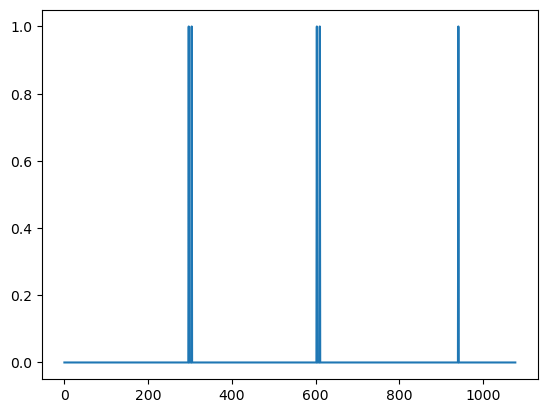

In [ ]:
'''split the spike time vector by trial '''

n_neurons = len(spike_times)
n_trials = df_task_ts.shape[0]
n_events = df_task_ts.shape[1] - 1 

len_times = np.zeros((n_trials, n_events), dtype=int)

spikes_binarized = np.zeros((n_neurons, n_trials, n_events), dtype=object)
unitary_neural_traj = np.zeros((n_units, n_trials),  dtype=object)

for unit_idx in range(n_neurons):
    data = df_task_ts_by_neuron[unit_idx][1]
    trial_unit = data.shape[0]

    for idx_trial in range(trial_unit):
        trial_ref = data.loc[idx_trial]['idx_ref_trial']


        for i in range(n_events):
            # define the start and end time of each trial
            t_start = data.loc[idx_trial][i+1]
            t_stop = data.loc[idx_trial][i+2]

            # get spikes between start and end of trial and align to zero
            spk_tmp = spike_times[unit_idx][1]
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            
            # get continuous spike trains
            n_times = (t_stop - t_start) + 1 
            spikes_bin = np.linspace(0, 0, num=n_times,  dtype=float)

            if unit_idx == completeUnit : 
                len_times[trial_ref][i] = n_times


            for spk in spk_tmp[sel_spk]:
                spk_aligned = spk - t_start
                spikes_bin[spk_aligned] = 1

            
            spikes_binarized[unit_idx][trial_ref][i] = {
                'unit_label': unit_label[unit_idx], 
                'trial_unit' : idx_trial, 
                'event' : event_labels[i],
                'spike_bin' : spikes_bin
                }
                
            unitary_neural_traj[unit_idx, trial_ref] = np.hstack(spikes_bin)
                
plt.plot(spikes_binarized[completeUnit][0][0]['spike_bin'])

In [ ]:
spikes_binarized_list = []

trial_list = np.arange(n_trials_tot)
trial_list_units = []

for unit_idx in range(n_units):
    df = df_task_ts_by_neuron[unit_idx][1]

    trials_units_in = list(df_task_ts_by_neuron[0][1].idx_ref_trial.values)
    trials_units_out = np.setdiff1d(trial_list, trials_units_in)
    trial_list_units.append(dict({'trials_in' : trials_units_in, 'trials_out':trials_units_out}))
    
    for trial in trial_list :
        #trial_ref = df.loc[trial]['idx_ref_trial']
        t_start = df_task_ts.loc[trial][0]
        t_stop = df_task_ts.loc[trial][-1]
        n_times = int(t_stop - t_start) + 1
        spikes_bin = np.zeros((n_times,), dtype=float)


        if trial in trials_units_in :
            # get spikes between start and end of trial and align to zero
            spk_tmp = spike_times[unit_idx][1]
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
  
            for spk in spk_tmp[sel_spk]:
                spk_aligned = int(spk - t_start) 
                spikes_bin[spk_aligned] = 1


        spikes_binarized_list.append((unit_idx, trial, spikes_bin))


In [ ]:
'''split the spike time vector by trial '''


spikes_binarized_list = []
trial_list = np.arange(n_trials_tot)

for unit_idx in range(n_units):
    df = df_task_ts_by_neuron[unit_idx][1]
    trials_unit = df.shape[0]

    for trial in trial_list[:trials_unit]:
        trial_ref = df.loc[trial]['idx_ref_trial']
        t_start = df_task_ts.loc[trial][0]
        t_stop = df_task_ts.loc[trial][-1]
        n_times = int(t_stop - t_start) + 1
        spikes_bin = np.zeros((n_times,), dtype=float)


        if trial_ref == trial :
            # get spikes between start and end of trial and align to zero
            spk_tmp = spike_times[unit_idx][1]
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
  
            for spk in spk_tmp[sel_spk]:
                spk_aligned = int(spk - t_start) 
                spikes_bin[spk_aligned] = 1

        #plt.plot(spikes_bin)
        spikes_binarized_list.append((unit_idx, trial, spikes_bin))

In [ ]:
#Verify the content of the list
for unit_idx, trial, spikes_bin in spikes_binarized_list:
    print(f'unit{unit_idx}, trial = {trial}, n_times = {spikes_bin.shape[0]}')

unit0, trial = 0, n_times = 6924
unit0, trial = 1, n_times = 6912
unit0, trial = 2, n_times = 7061
unit0, trial = 3, n_times = 6944
unit0, trial = 4, n_times = 7066
unit0, trial = 5, n_times = 6943
unit0, trial = 6, n_times = 6787
unit0, trial = 7, n_times = 6836
unit0, trial = 8, n_times = 7074
unit0, trial = 9, n_times = 6835
unit0, trial = 10, n_times = 6845
unit0, trial = 11, n_times = 6919
unit0, trial = 12, n_times = 6992
unit0, trial = 13, n_times = 6876
unit0, trial = 14, n_times = 7249
unit0, trial = 15, n_times = 7034
unit0, trial = 16, n_times = 6886
unit0, trial = 17, n_times = 6996
unit0, trial = 18, n_times = 7056
unit0, trial = 19, n_times = 6989
unit0, trial = 20, n_times = 6836
unit0, trial = 21, n_times = 6939
unit0, trial = 22, n_times = 6933
unit0, trial = 23, n_times = 6796
unit0, trial = 24, n_times = 6936
unit0, trial = 25, n_times = 6910
unit0, trial = 26, n_times = 6870
unit0, trial = 27, n_times = 6792
unit0, trial = 28, n_times = 6916
unit0, trial = 29, n_tim

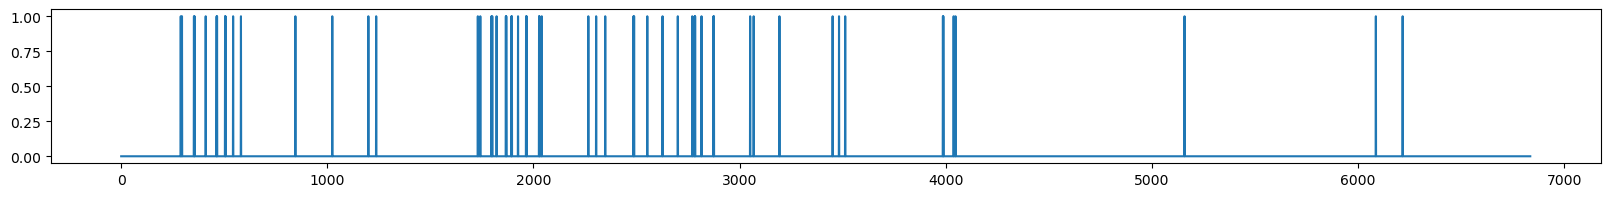

In [60]:
unit_to_plot = 32
trial_to_plot = 20

plt.figure(figsize=(20,2))

for dim in spikes_binarized_list:
    if dim[0] == unit_to_plot and dim[1] == trial_to_plot:
        plt.plot(dim[2])

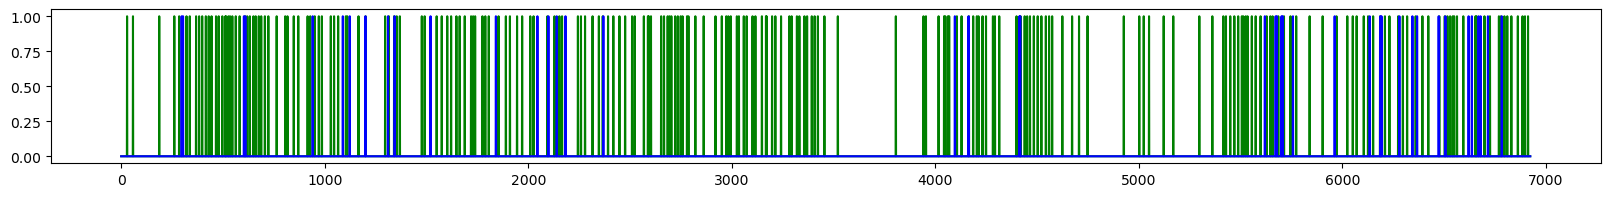

In [34]:
unit_to_plot = [32, 20]
trial_to_plot = 0

plt.figure(figsize=(20,2))

for dim in spikes_binarized_list:
    if dim[0] in unit_to_plot and dim[1] == trial_to_plot:
        if dim[0] == 32 : 
            color='b'
        else : 
            color='g'
        plt.plot(dim[2], color=color)

In [25]:
import scipy.ndimage as spn 

spikes_convol_list = []

sigma = [50]
n_sigma = len(sigma)
delta_time = 1
sigma_dt = sigma[0] * delta_time 
scaling = sigma_dt * np.sqrt(2*np.pi)

for dim in spikes_binarized_list:
    smoothed_spk_ = spn.gaussian_filter1d(dim[2], sigma_dt) * scaling
    spikes_convol_list.append((dim[0], dim[1],smoothed_spk_))

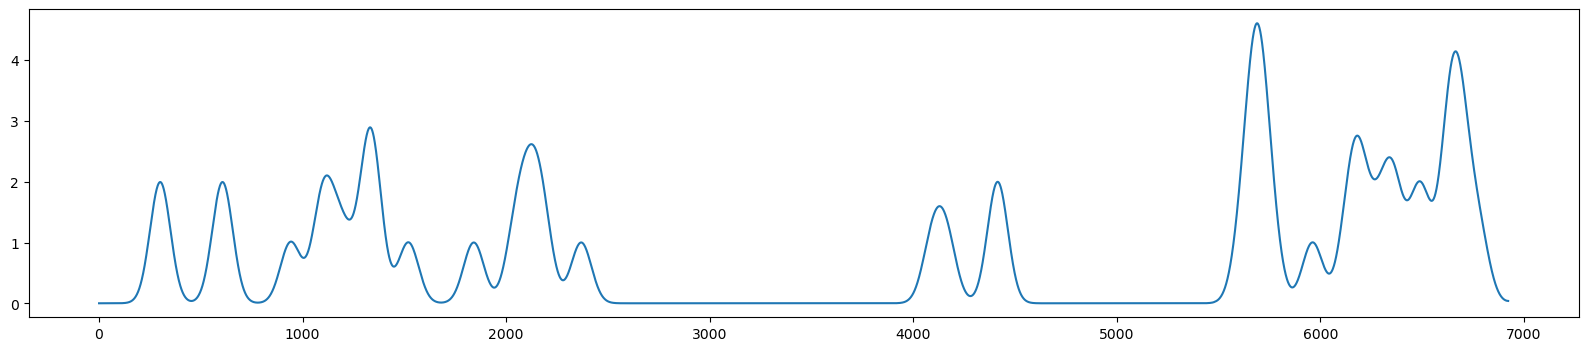

In [26]:
unit_to_plot = [completeUnit]
trial_to_plot = 0
        
plt.figure(figsize=(20,4))

for dim in spikes_convol_list:
    if dim[0] in unit_to_plot and dim[1] == trial_to_plot:
        plt.plot(dim[2])

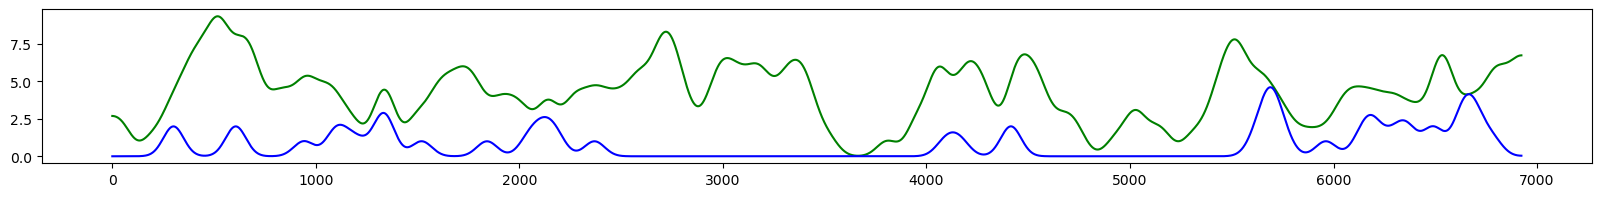

In [35]:
unit_to_plot = [32, 20]
trial_to_plot = 0

plt.figure(figsize=(20,2))

for dim in spikes_convol_list:
    if dim[0] in unit_to_plot and dim[1] == trial_to_plot:
        if dim[0] == 32 : 
            color='b'
        else : 
            color='g'
        plt.plot(dim[2], color=color)

In [50]:
spikes_convol_list

[(0, 0, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 1, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 2, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 3, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 4, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 5, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 6, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 7, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 8, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 9, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 10, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 11, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 12, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 13, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 14, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 15, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 16, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 17, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 18, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 19, array([0., 0., 0., ..., 0., 0., 0.])),
 (0, 20, array([0., 0., 0., ..., 0., 0., 0.])),
 (

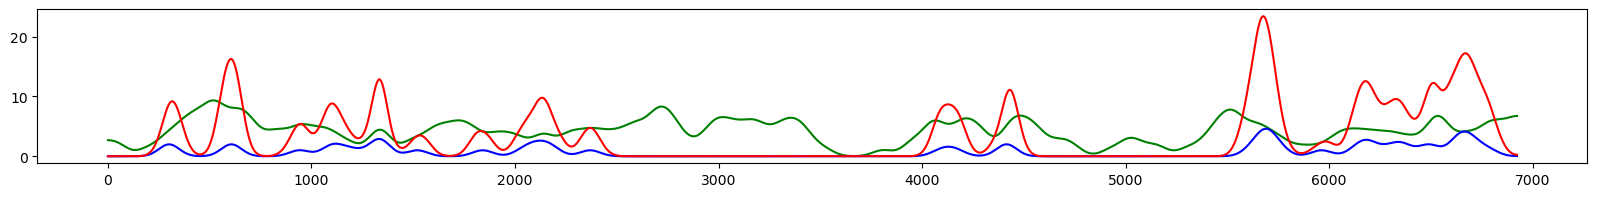

In [58]:
unit_to_plot = [32, 20]
trial_to_plot = 0

plt.figure(figsize=(20,2))

for dim in spikes_convol_list:

    if dim[0] in unit_to_plot and dim[1] == trial_to_plot:

        if dim[0] == 32 and dim[1] == trial_to_plot : 
            traj1 = dim[2]
            color='b'

            plt.plot()
        elif dim[0] == 20 and dim[1] == trial_to_plot :
            traj2 = dim[2]
            color='g'
        plt.plot(dim[2], color=color)


    
plt.plot(traj1*traj2, color='r')

In [41]:
neural_traj = []

for unit_idx in range(2):

    traj = []
    for dim in spikes_convol_list:
        if dim[0] == unit_idx :
            traj.append(dim[2])

    print(len(traj))
    
    dict_ = \
    {
        'trial_type': target['trial_type'],
        'position' : target['position'],
        'type_and_pos' : target['type_and_pos'], 
        'traj' : traj

    }
        
    df = pd.DataFrame(dict_, index=trial_list)
    neural_traj.append(df)


49


ValueError: Length of values (49) does not match length of index (176)

In [263]:
 neural_traj[0]['traj'][neural_traj[0].trial_type == trial_type_[0]]

0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                             ...                        
167    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
168    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
169    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
170    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
171    [0.2761822999880451, 0.2765092157409055, 0.277...
Name: traj, Length: 72, dtype: object

In [46]:
traj_ = neural_traj[0]
sub_traj = traj_['traj'][traj_['trial_type'] == trial_type_[0]]
sub_trial = sub_traj.shape[0]

for t in range(sub_trial): 
    print(t)
    plt.plot(sub_traj.iloc[t])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


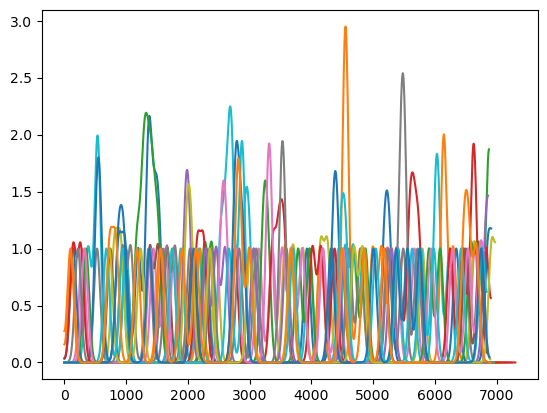

In [48]:
for t in range(sub_trial): 
    print(t)
    plt.plot(sub_traj.iloc[t])

In [42]:
sub_traj.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171],
      dtype='int64')

In [43]:
sub_traj.iloc[-1]

array([0.2761823 , 0.27650922, 0.27716282, ..., 0.01171053, 0.01162424,
       0.01158114])

In [38]:
sub_traj.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171],
      dtype='int64')

# Trial type

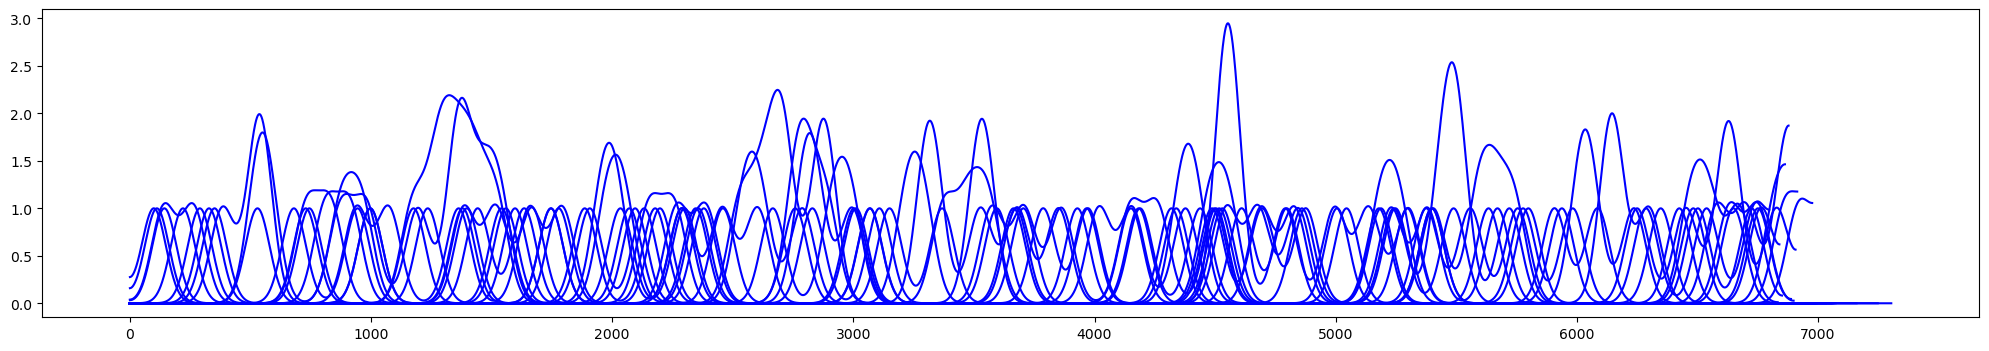

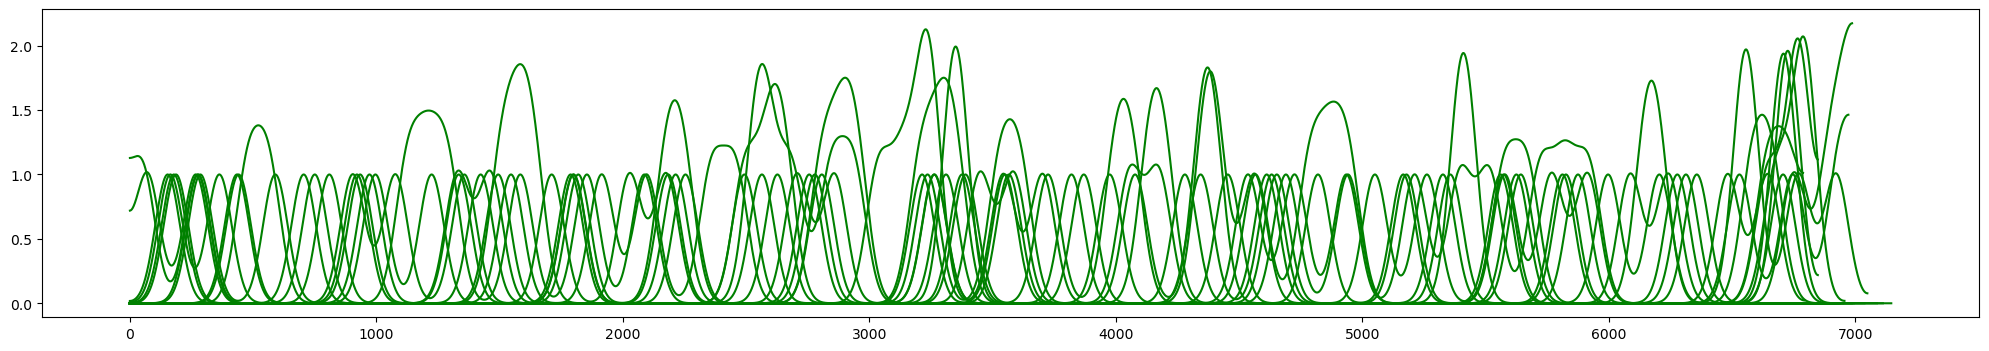

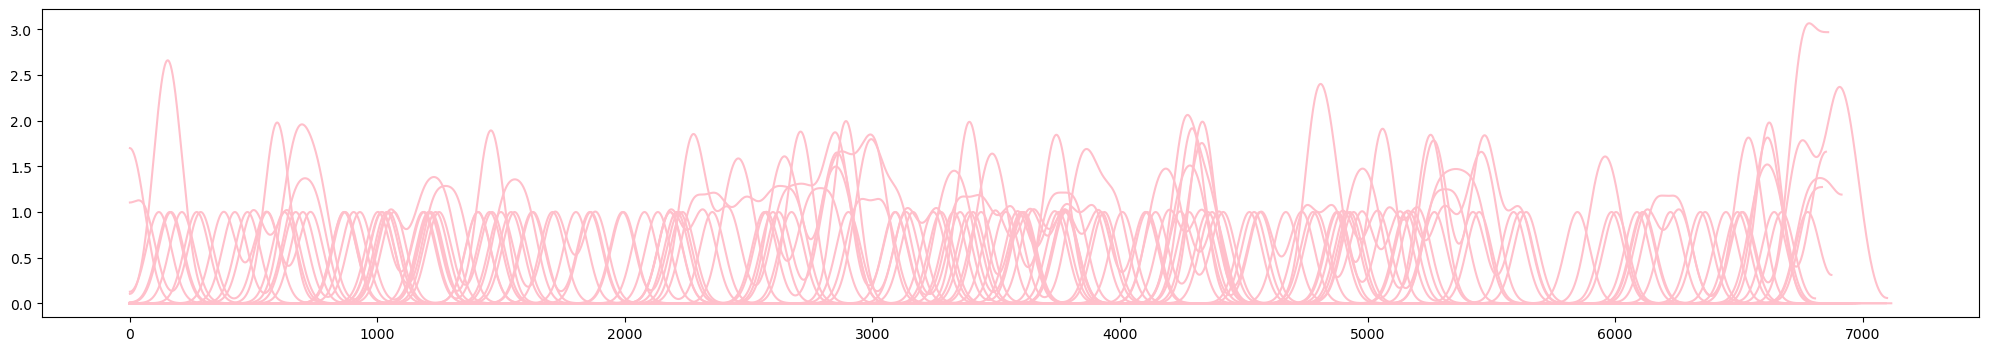

In [51]:
trial_type_ = [1,2,3]

traj_ = neural_traj[0]
palette = ['b', 'g', 'pink']

i= -1 

for type_ in trial_type_ :
    i +=1

    plt.figure(figsize=(25,4))
    
    sub_traj = traj_['traj'][traj_['trial_type'] == type_]
    sub_trial = sub_traj.shape[0]

    for t in range(sub_trial): 
        plt.plot(sub_traj.iloc[t], color=palette[i])


# Position [trial_type 1]

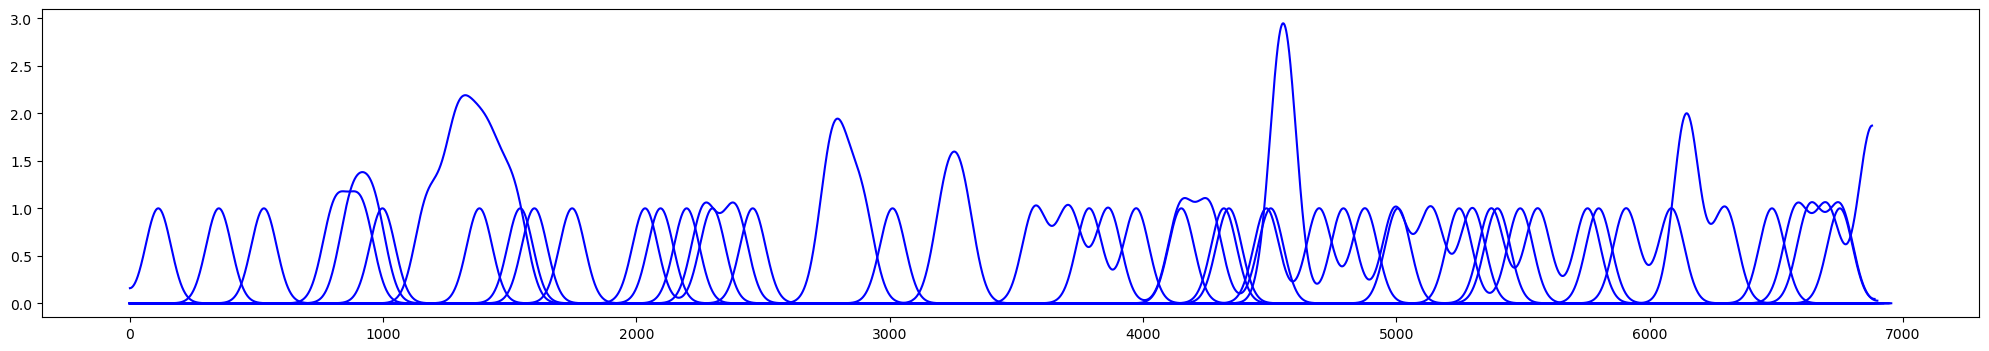

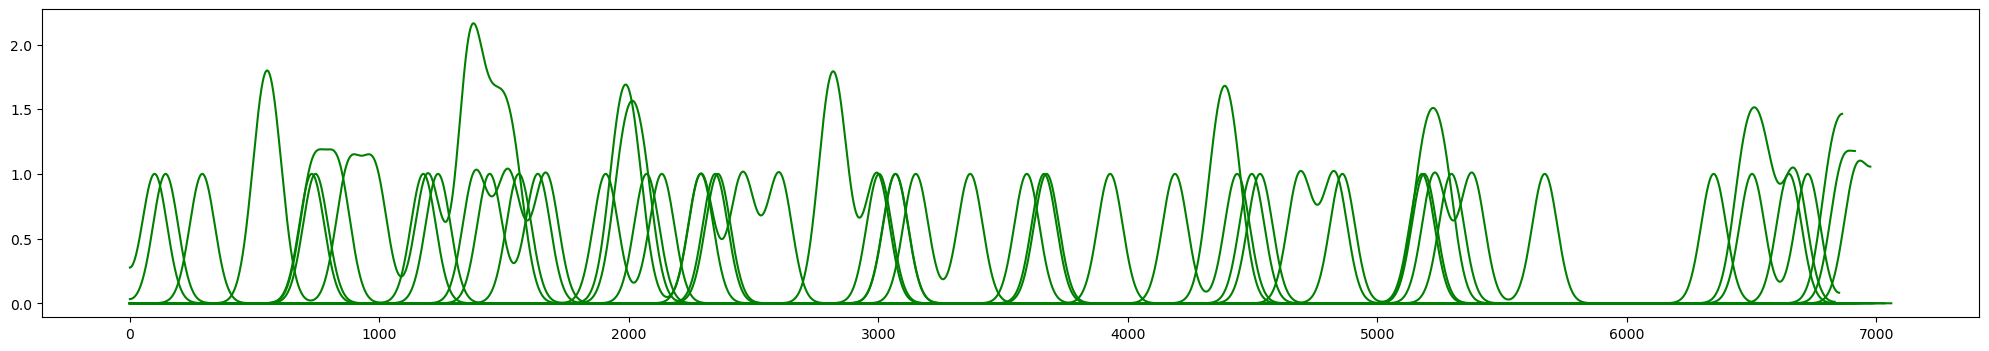

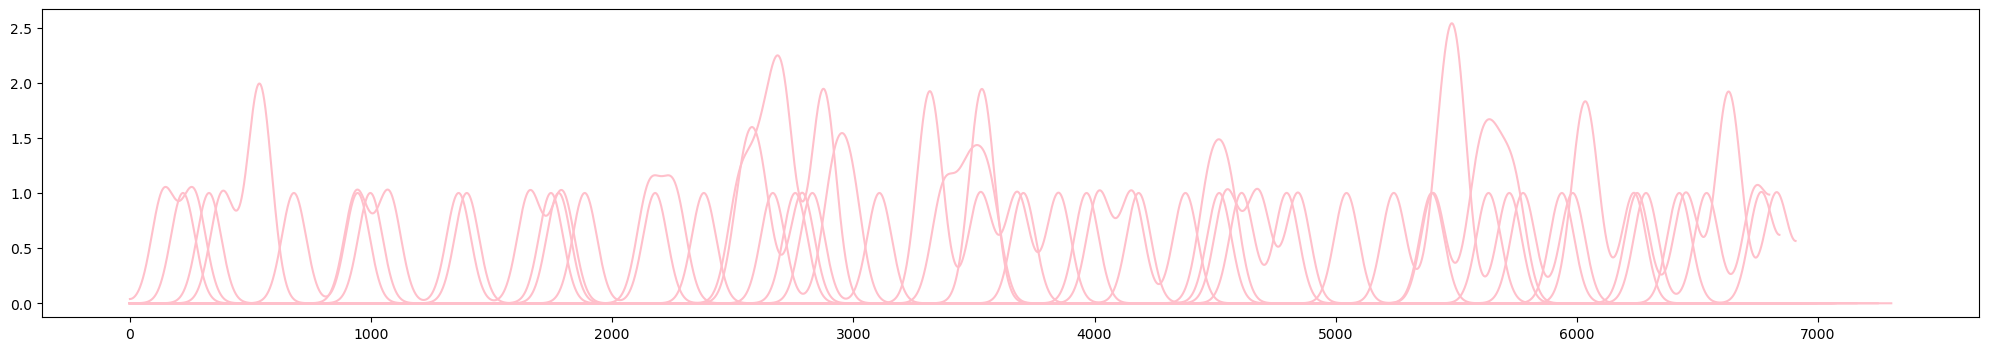

In [56]:
type_pos = [0,1,2]

traj_ = neural_traj[0]
palette = ['b', 'g', 'pink']

i= -1 

for type_ in type_pos :
    i +=1

    plt.figure(figsize=(25,4))
    
    sub_traj = traj_['traj'][traj_['type_and_pos'] == type_]
    sub_trial = sub_traj.shape[0]

    for t in range(sub_trial): 
        plt.plot(sub_traj.iloc[t], color=palette[i])


# Position 

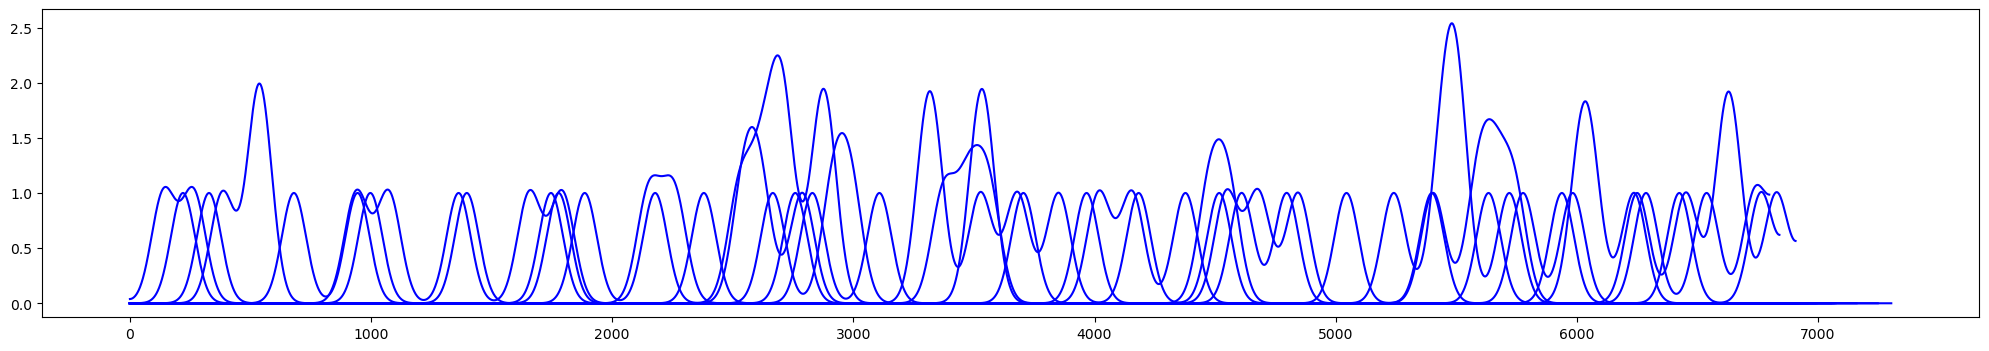

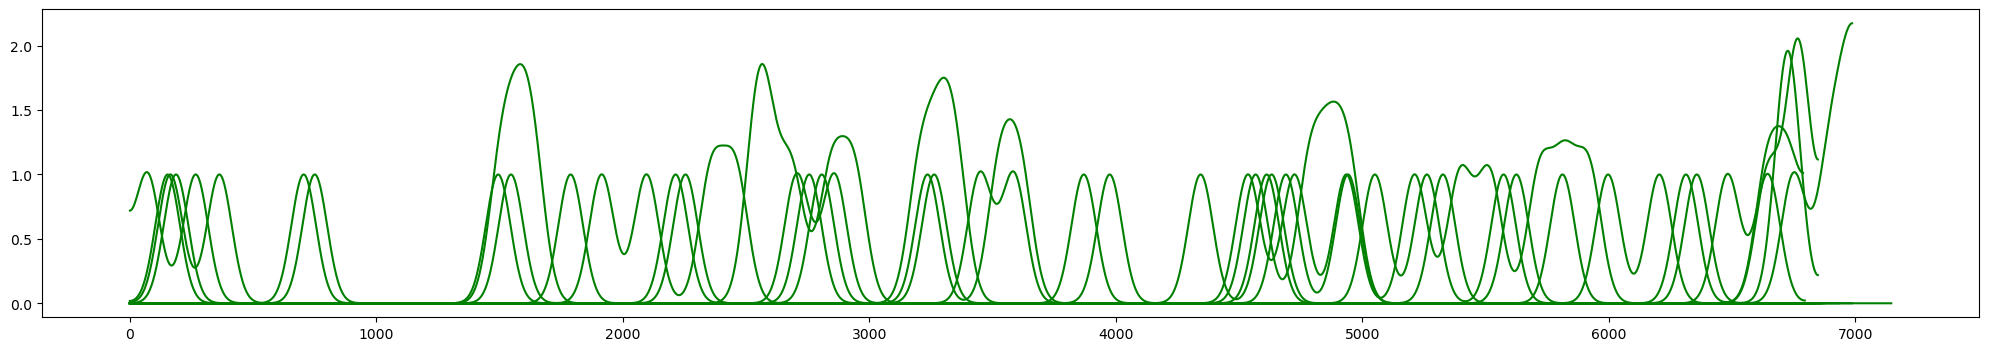

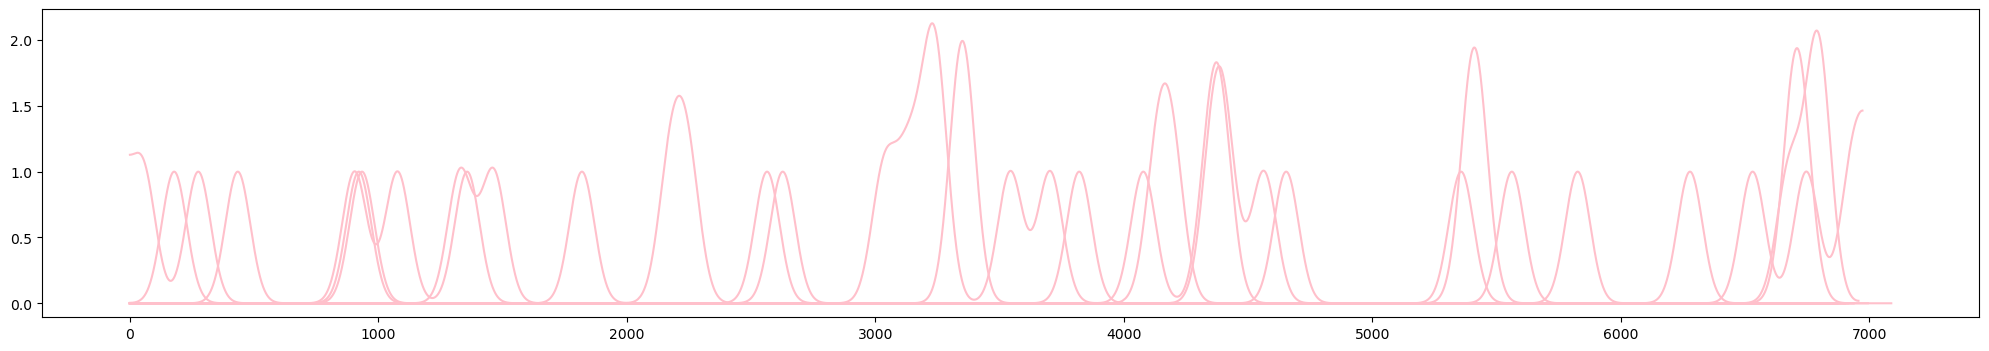

In [55]:
pos = [2,3,4]

traj_ = neural_traj[0]
palette = ['b', 'g', 'pink']

i= -1 

for type_ in pos :
    i +=1

    plt.figure(figsize=(25,4))
    
    sub_traj = traj_['traj'][traj_['type_and_pos'] == type_]
    sub_trial = sub_traj.shape[0]

    for t in range(sub_trial): 
        plt.plot(sub_traj.iloc[t], color=palette[i])


In [67]:
trial_type_ = [1, 2, 3]
type_pos = [[0,1,2], [2,3,4], [5,6,7]]

p = -1
for t_ in trial_type_:
    p += 1 

    plt.figure(figsize=(25,4))
    
    sub_traj = traj_['traj'][traj_['trial_type'] == t_]
    sub_trial = sub_traj.shape[0]

    for t in range(sub_trial): 
        plt.plot(sub_traj.iloc[t], color=palette[i])

'''
    #print(t)
        for i in type_pos[p]:
            sub_traj_ = traj_['traj'][traj_['trial_type'] == t_]
            sub_trial = sub_traj.shape[0]

        for t in range(sub_trial): 
            plt.plot(sub_traj.iloc[t], color=palette[i])
                print(i) 
'''

#####0#####
0
1
2
#####1#####
2
3
4
#####2#####
5
6
7


In [301]:
sub_traj.index

Index([ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155],
      dtype='int64')

In [296]:
sub_traj.iloc[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [292]:
sub_traj

37     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
38     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
39     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
40     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
41     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
42     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
43     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
44     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
45     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
46     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
47     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
48     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
49     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
50     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
51     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
52     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
53     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
91     [0.0, 0.0, 0.0, 0.0, 0.0

In [291]:
sub_traj.iloc[73]

IndexError: single positional indexer is out-of-bounds

In [277]:
sub_trial = sub_data.index.to_list()
for t in sub_trial:
    print(t)


37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
91
92
93
94
95
96
97
98
99
100
101
102
103
104
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


In [275]:
sub_data.index.to_list()

[37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155]

In [209]:
df.loc[0][2]

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

<Axes: >

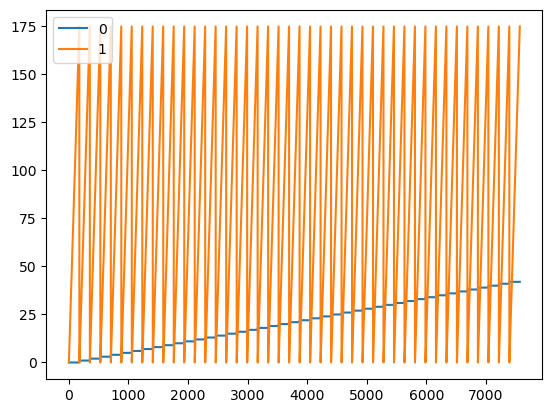

In [210]:
df.plot()

In [ ]:
for dim in spikes_binarized_list:
    spikes_convol_list.append((dim[0], dim[1],smoothed_spk_))

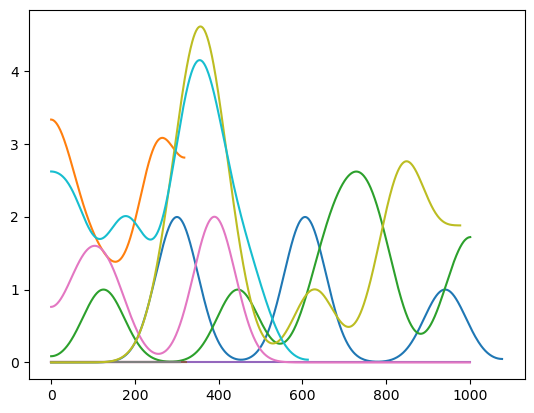

In [101]:
for i in range(n_events):
    plt.plot(spike_convolved[completeUnit][0][0][i])

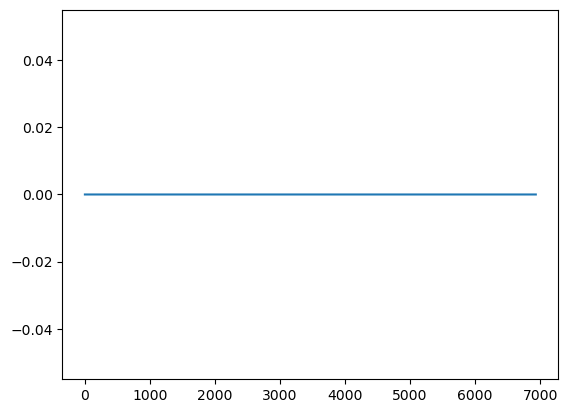

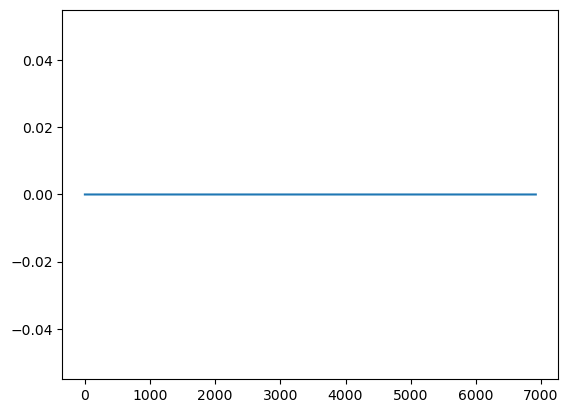

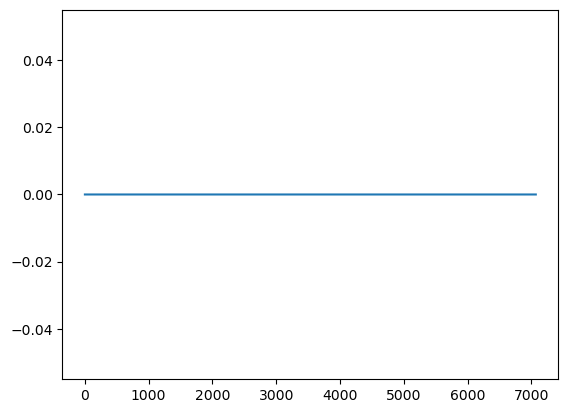

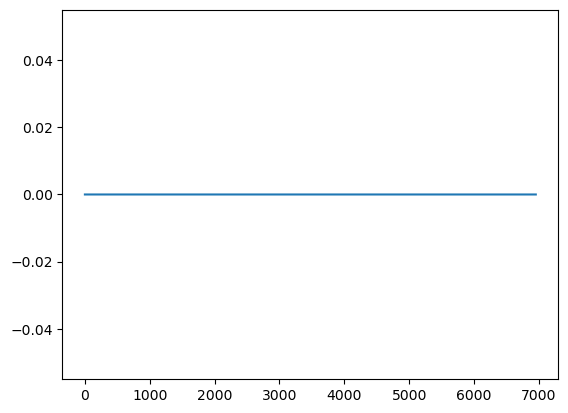

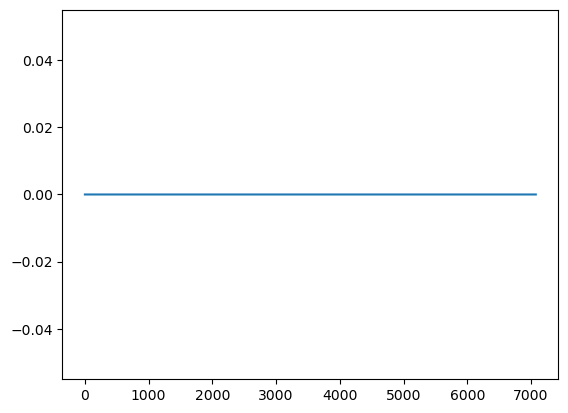

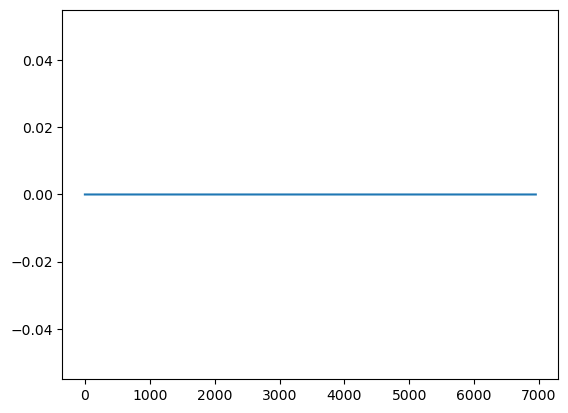

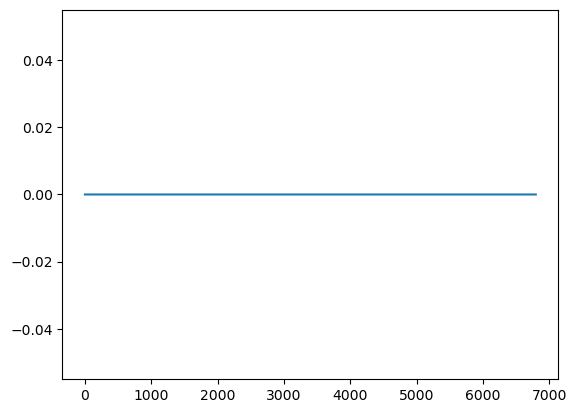

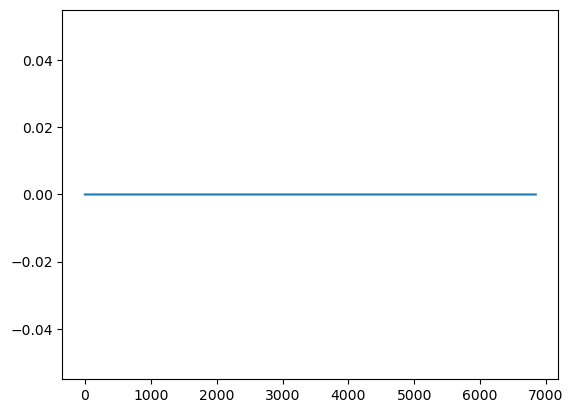

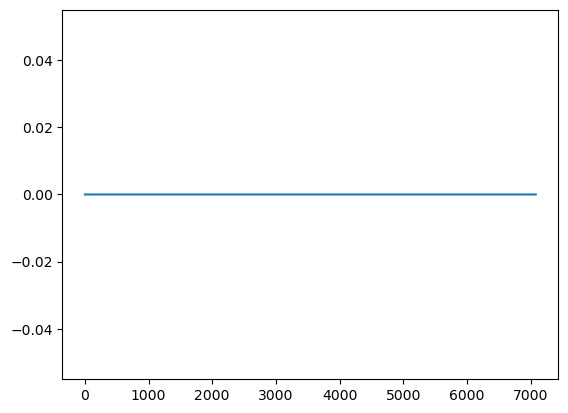

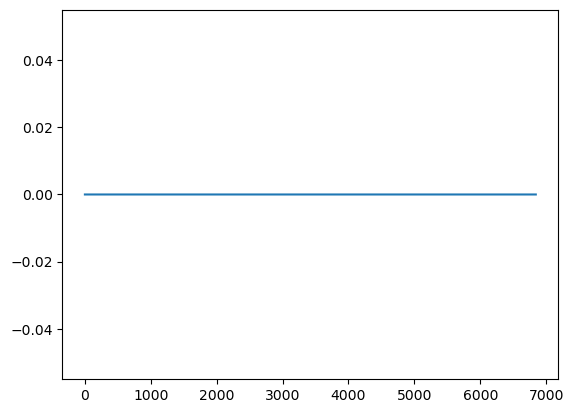

In [52]:
for trial in range(10):
    plt.figure()
    plt.plot(unitary_neural_traj[1][trial])

In [ ]:
# plot population trajectory
sig = 0
trial = 0
event = 0
data = neural_traj[sig][trial][event]
unit = completeUnit
convol = spike_convolved[unit, sig, trial, event]
n_times = convol.shape[0] - 1



# Create a color palette with different colors every n_times points
palette = sns.color_palette("husl", n_colors=(data.shape[0] // n_times))

# Plot the population trajectory with seaborn
plt.figure(figsize=(25, 4))
for i in range(0, data.shape[0], n_times):
    color = palette[i // (n_times+1)]
    plt.plot(np.arange(i, min(i + n_times, data.shape[0])), data[i:min(i + n_times, data.shape[0])], color=color)

plt.xlim(0, data.shape[0])

# Show the plot
plt.show()
